In [2]:

import numpy as np
import matplotlib.pyplot as plt
import mitsuba as mi
from integrator import SimpleIntegrator, DirectIntegrator
mi.set_variant('cuda_ad_rgb')

In [3]:
scene = mi.load_file('cornell_box.xml')
path_integrator = SimpleIntegrator()

seed = 12345
low_spp = 8

# Low-sample path tracing (our noisy estimate)
L_path_low = np.array(mi.render(scene, integrator=path_integrator, spp=low_spp, seed=seed))

# Perfect control variate: same integrator, same seed
L_perfect_low = np.array(mi.render(scene, integrator=path_integrator, spp=low_spp, seed=seed))

# Ground truth
ground_truth = np.array(mi.render(scene, integrator=path_integrator, spp=4096))
E_perfect = ground_truth

# With perfect correlation, alpha=1.0 gives optimal variance reduction
for alpha in [0.0, 0.5, 1.0]:
    L_cv = L_path_low + alpha * (E_perfect - L_perfect_low)
    mse = np.mean((L_cv - ground_truth) ** 2)
    print(f"Perfect CV - Alpha: {alpha:.2f}, MSE: {mse:.6f}")

direct_integrator = DirectIntegrator()

# Direct lighting with same seed (correlated first bounce)
L_direct_low = np.array(mi.render(scene, integrator=direct_integrator, spp=low_spp, seed=seed))
E_direct = np.array(mi.render(scene, integrator=direct_integrator, spp=1024))

for alpha in [0.0, 0.5, 1.0]:
    L_cv = L_path_low + alpha * (E_direct - L_direct_low)
    mse = np.mean((L_cv - ground_truth) ** 2)
    print(f"Direct CV - Alpha: {alpha:.2f}, MSE: {mse:.6f}")

Perfect CV - Alpha: 0.00, MSE: 0.001563
Perfect CV - Alpha: 0.50, MSE: 0.000391
Perfect CV - Alpha: 1.00, MSE: 0.000000
Direct CV - Alpha: 0.00, MSE: 0.001563
Direct CV - Alpha: 0.50, MSE: 0.000428
Direct CV - Alpha: 1.00, MSE: 0.000056


In [6]:
def create_scaled_scene(scale=1.20):
    """Create scene with scaled box geometry."""
    # Load base scene and modify box transforms
    # Scale boxes around their centers by the given factor
    local_scene = mi.load_file('cornell_box.xml')
    params = mi.traverse(local_scene)
    smallbox_mesh = None
    largebox_mesh = None
    for shape in (local_scene.shapes()):
        if shape.id() == "smallbox":
            smallbox_mesh = shape
        elif shape.id() == "largebox":
            largebox_mesh = shape
    new_pos_list = [] 
    centroid = mi.Vector3f(0,0,0)
    for i in range(smallbox_mesh.vertex_count()):
        pos = smallbox_mesh.vertex_position(i, True)
        centroid += mi.Vector3f(pos.x, pos.y, pos.z)
    centroid /= smallbox_mesh.vertex_count()

    for i in range(smallbox_mesh.vertex_count()):
        pos = smallbox_mesh.vertex_position(i, True)
        new_pos = mi.Transform4f.scale([scale, scale, scale]) @ (pos - centroid) + centroid
        new_pos_list.append(new_pos)
    new_pos_list = np.array(new_pos_list).flatten()
    new_pos_list = mi.Float32(new_pos_list)
    params["smallbox.vertex_positions"] = new_pos_list

    new_pos_list = []
    centroid = mi.Vector3f(0,0,0)
    for i in range(largebox_mesh.vertex_count()):
        pos = largebox_mesh.vertex_position(i, True)
        centroid += mi.Vector3f(pos.x, pos.y, pos.z)
    centroid /= largebox_mesh.vertex_count()
    for i in range(largebox_mesh.vertex_count()):
        pos = largebox_mesh.vertex_position(i, True)
        new_pos = mi.Transform4f.scale([scale, scale, scale]) @ (pos - centroid) + centroid
        new_pos_list.append(new_pos)
    new_pos_list = np.array(new_pos_list).flatten()
    new_pos_list = mi.Float32(new_pos_list)
    params["largebox.vertex_positions"] = new_pos_list
    params.update()
    return local_scene 

In [ ]:
def visualize_cv_results(name, L_low, E_high, L_cv_low, ground_truth, alphas):
    """Create visualization for a control variate approach."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Row 1: Inputs and CV renders at different alphas
    # Row 2: Error images and MSE plot

    results = []
    for alpha in alphas:
        cv_image = L_low + alpha * (E_high - L_cv_low)
        error = cv_image - ground_truth
        mse = np.mean(error ** 2)
        results.append({'alpha': alpha, 'mse': mse, 'image': cv_image, 'error': error})

    # Plot renders at alpha = 0.0, 0.5, 1.0
    # Plot corresponding error images (amplified)
    # Plot MSE vs alpha curve
    for i, alpha in enumerate(alphas):
        ax = axes[0, i]
        img = results[[r['alpha'] for r in results].index(alpha)]['image']
        ax.imshow(np.clip(img, 0, 1))
        ax.set_title(f'Alpha = {alpha:.2f}')
        ax.axis('off')

        ax_err = axes[1, i]
        err = results[[r['alpha'] for r in results].index(alpha)]['error']
        ax_err.imshow(np.clip(err * 10 + 0.5, 0, 1))  # Amplify error for visibility
        ax_err.set_title(f'Error (x10) Alpha = {alpha:.2f}')
        ax_err.axis('off')

    # Plot MSE vs alpha curve
    ax_mse = axes[1, 3]
    ax_mse.plot([r['alpha'] for r in results], [r['mse'] for r in results], marker='o')
    ax_mse.set_title('MSE vs Alpha')
    ax_mse.set_xlabel('Alpha')
    ax_mse.set_ylabel('MSE')
    ax_mse.grid(True)

In [8]:
scaled_scene = create_scaled_scene(scale=1.20)

# Scaled scene with same seed
L_scaled_low = np.array(mi.render(scaled_scene, integrator=path_integrator, spp=low_spp, seed=seed))
E_scaled = np.array(mi.render(scaled_scene, integrator=path_integrator, spp=1024))

for alpha in [0.0, 0.5, 1.0]:
    L_cv = L_path_low + alpha * (E_scaled - L_scaled_low)
    mse = np.mean((L_cv - ground_truth) ** 2)
    print(f"Scaled CV - Alpha: {alpha:.2f}, MSE: {mse:.6f}")

Scaled CV - Alpha: 0.00, MSE: 0.001563
Scaled CV - Alpha: 0.50, MSE: 0.000422
Scaled CV - Alpha: 1.00, MSE: 0.000079


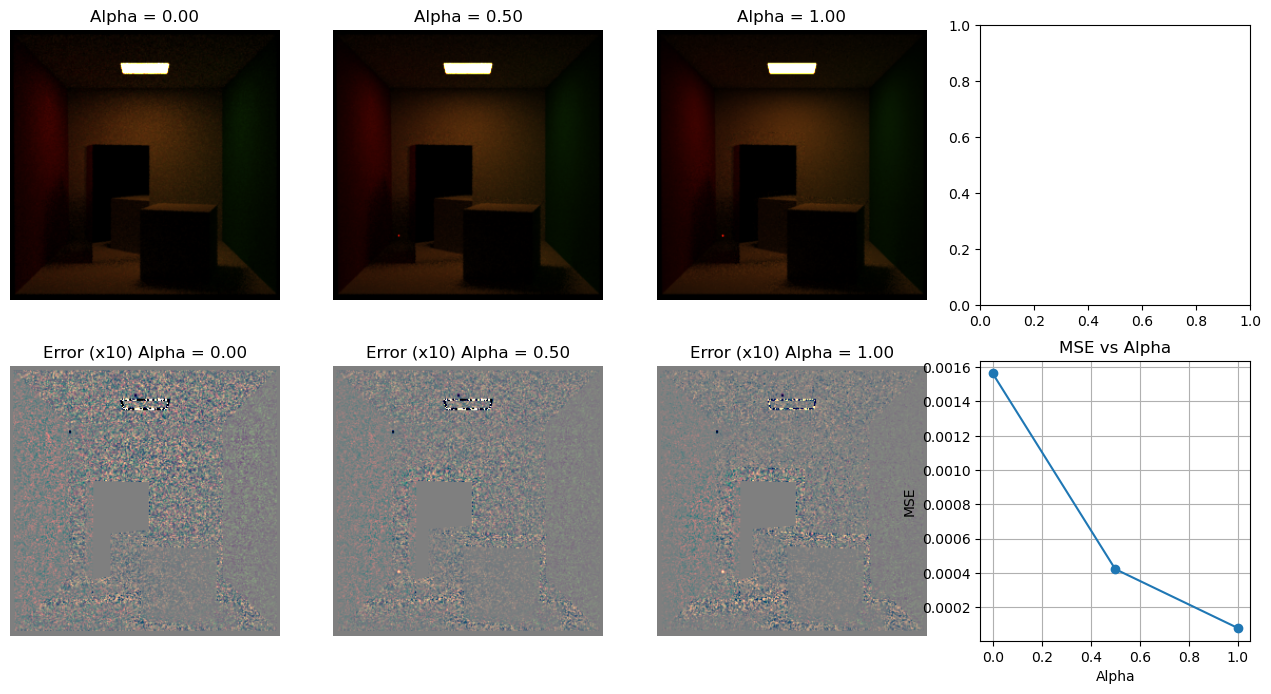

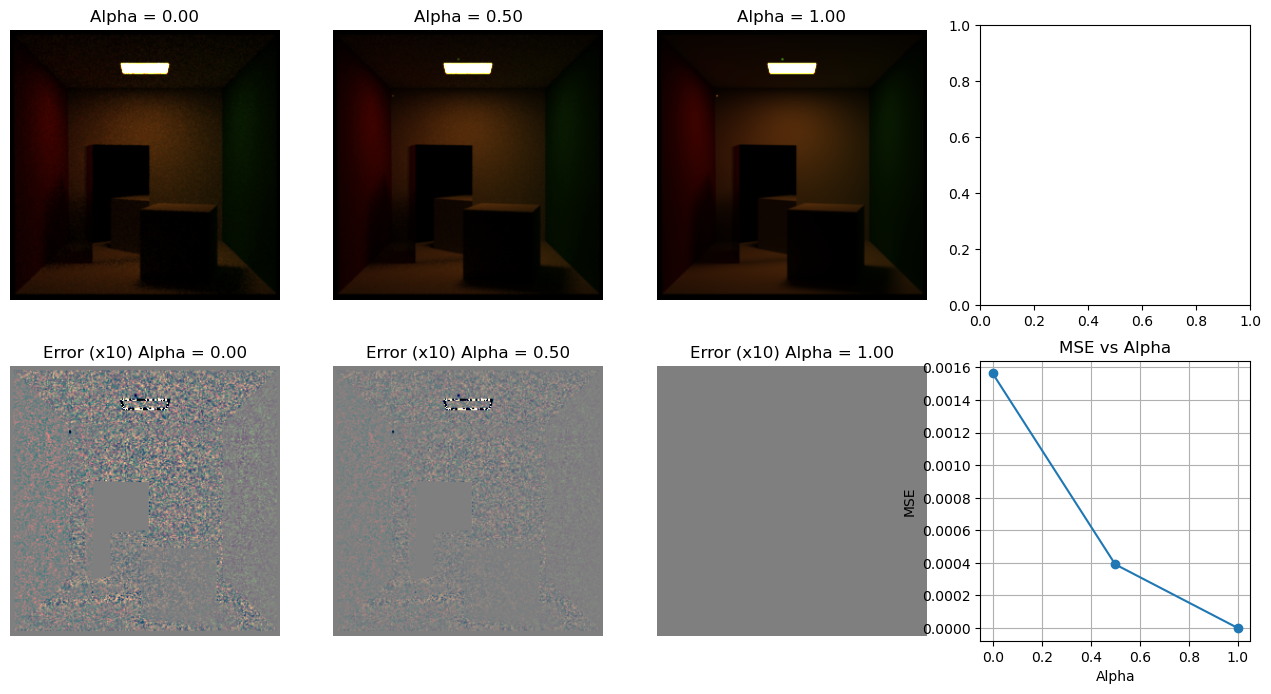

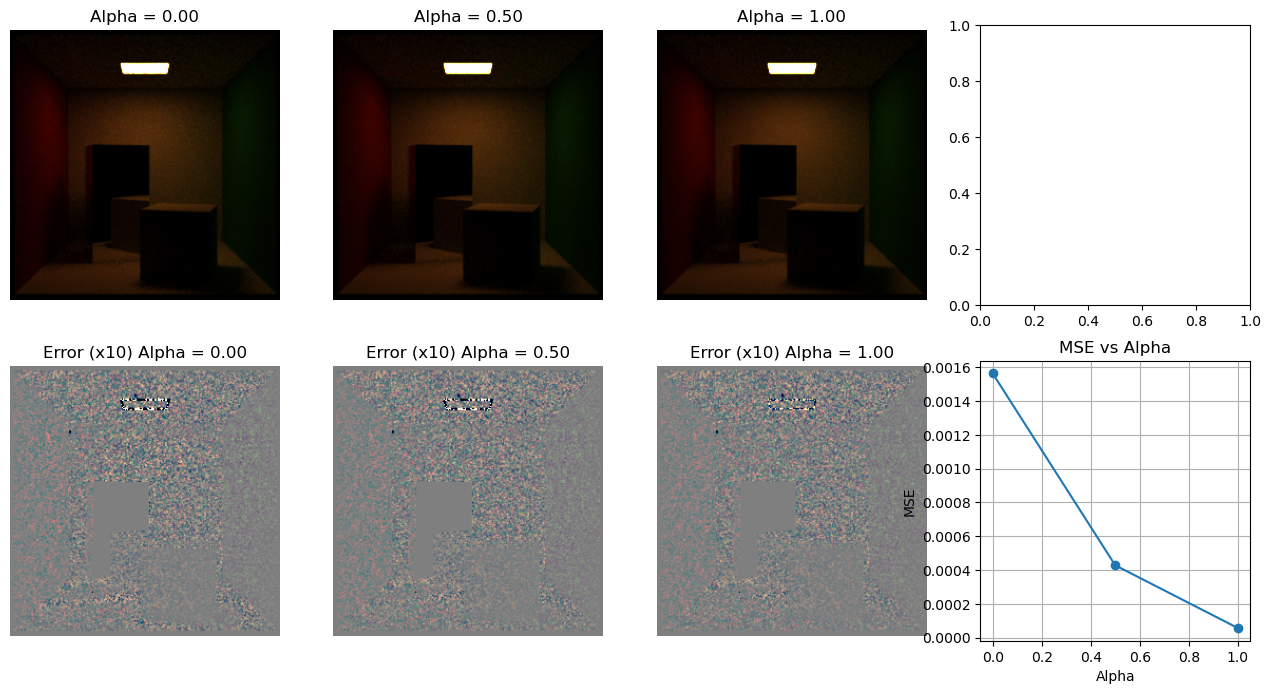

In [9]:
visualize_cv_results('scaled_scene', L_path_low, E_scaled, L_scaled_low, ground_truth, alphas=[0.0, 0.5, 1.0])
visualize_cv_results('perfect_cv', L_path_low, E_perfect, L_perfect_low, ground_truth, alphas=[0.0, 0.5, 1.0])
visualize_cv_results('direct_cv', L_path_low, E_direct, L_direct_low, ground_truth, alphas=[0.0, 0.5, 1.0])